<a href="https://colab.research.google.com/github/EmmanueleVilla/quantum_computing/blob/main/Colab_17_L'algoritmo_di_Shor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
!pip install qiskit --quiet && pip install pylatexenc --quiet && pip install qiskit-aer --quiet

In [34]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, Aer, transpile, execute, assemble, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.visualization.state_visualization import array_to_latex
from math import gcd
from numpy.random import randint
import pandas as pd
from fractions import Fraction
from qiskit.circuit.library import QFT

## La funzione periodica

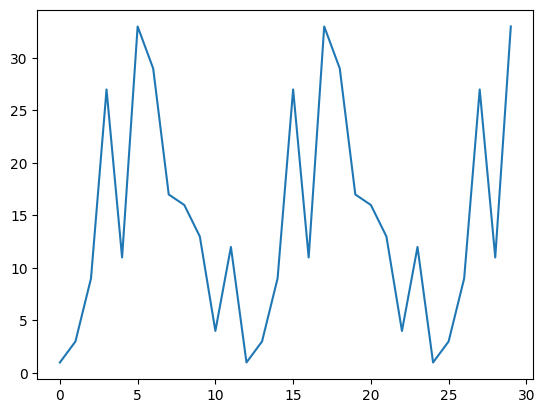

In [35]:
N = 35
a = 3
xvals = np.arange(30)
yvals = [np.mod(a**x, N) for x in xvals]

fig, ax = plt.subplots()
ax.plot(xvals, yvals)

## Soluzione classica

In [36]:
x = 1
a = 3
N = 35
while(True):
  y = np.mod(a**x, 35)
  if y == 1:
    print(x)
    break
  x += 1

12


## Operatore U

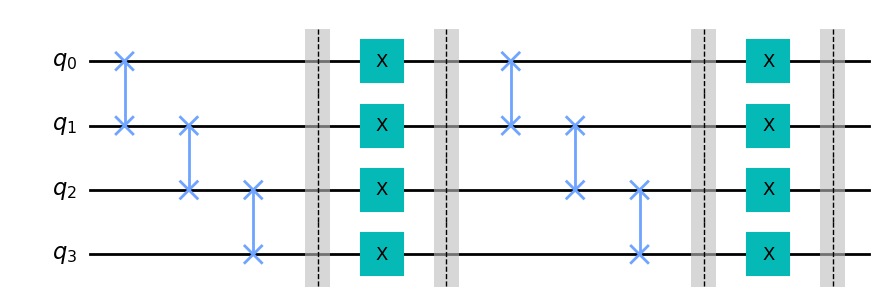

In [37]:
# Creo l'operatore U
a = 7
mod = 15
pow = 2

qc = QuantumCircuit(4)
for _iteration in range(pow):
  qc.swap(0,1)
  qc.swap(1,2)
  qc.swap(2,3)
  qc.barrier()
  qc.x(range(4))
  qc.barrier()
qc.draw(output="mpl")

## Soluzione quantistica

In [44]:
def c_amod15(a, power):
    if a not in [2,4,7,8,11,13]:
        raise ValueError("'a' must be 2,4,7,8,11 or 13")
    U = QuantumCircuit(4)
    for _iteration in range(power):
        if a in [2,13]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a in [7,8]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [4, 11]:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = f"{a}^{power} mod 15"
    c_U = U.control()
    return c_U

In [45]:
N_COUNT = 8
a = 7
N = 35

In [50]:
def qft_dagger(n):
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

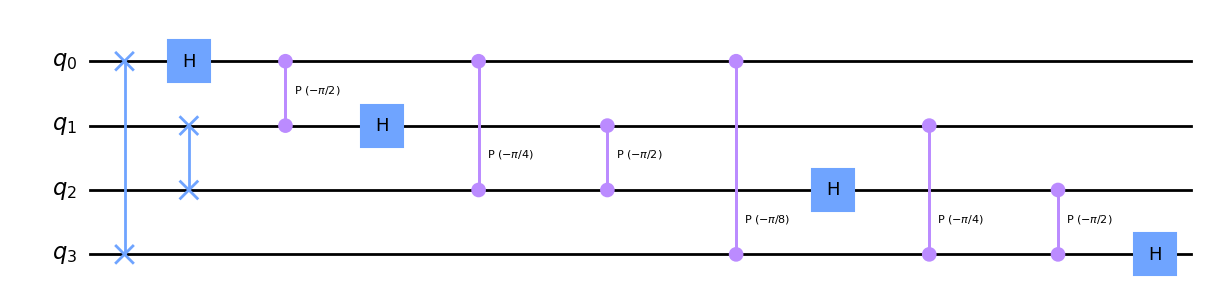

In [52]:
qft_dagger(4).draw(output="mpl")

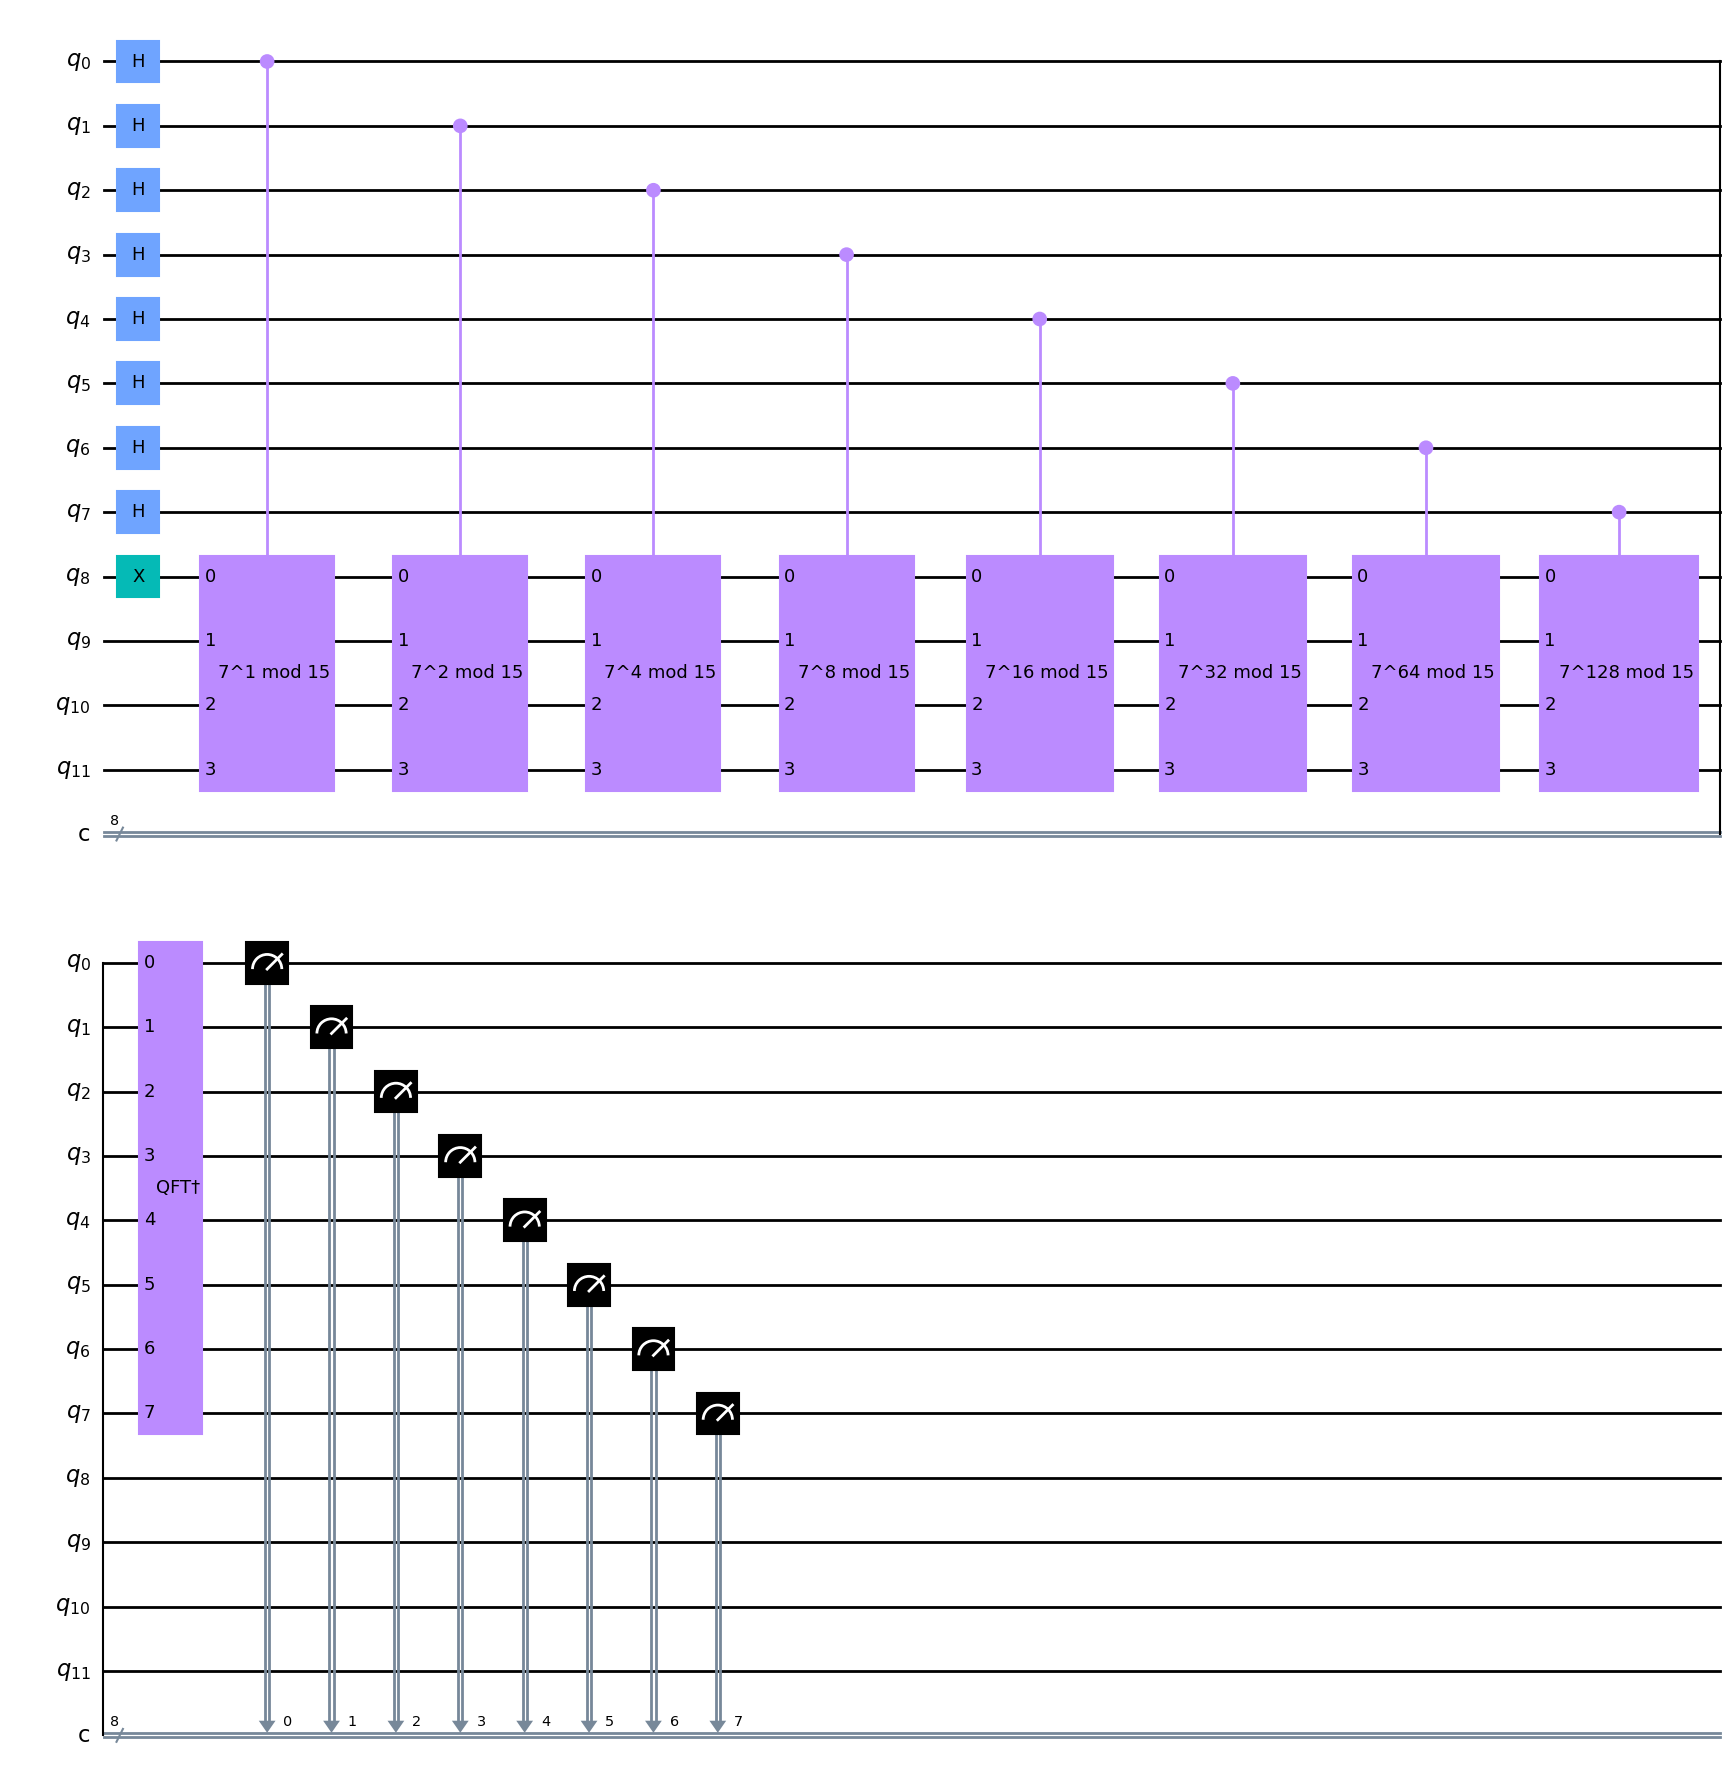

In [53]:
## Creo il circuito totale
qc = QuantumCircuit(N_COUNT + 4, N_COUNT)

qc.h(range(N_COUNT))

qc.x(N_COUNT)

for q in range(N_COUNT):
  qc.append(c_amod15(a, 2**q), [q] + [i+N_COUNT for i in range(4)])

qc.append(qft_dagger(N_COUNT), range(N_COUNT))

qc.measure(range(N_COUNT), range(N_COUNT))

qc.draw(output="mpl")

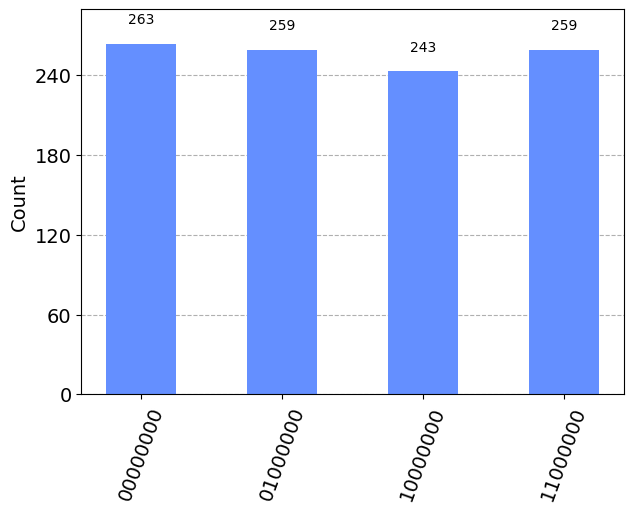

In [54]:
aer_sim = Aer.get_backend("aer_simulator")
t_qc = transpile(qc, aer_sim)
counts = aer_sim.run(t_qc).result().get_counts()
plot_histogram(counts)

In [55]:
# Divido i valori misurati per 2^8

In [60]:
rows, measured_phases = [], []
for output in counts:
  decimal = int(output, 2)
  phase = decimal/(2**N_COUNT)
  measured_phases.append(phase)
  rows.append([f"{output}(bin) = {decimal:>3}(dec)",
               f"{decimal}/{2**N_COUNT} = {phase:.2f}"])
headers = ["Output", "Fase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

                     Output            Fase
0  10000000(bin) = 128(dec)  128/256 = 0.50
1  11000000(bin) = 192(dec)  192/256 = 0.75
2  00000000(bin) =   0(dec)    0/256 = 0.00
3  01000000(bin) =  64(dec)   64/256 = 0.25


In [61]:
rows = []
for phase in measured_phases:
  frac = Fraction(phase).limit_denominator(15)
  rows.append(
      [phase, f"{frac.numerator}/{frac.denominator}", frac.denominator]
  )
headers = ["Fase", "Frazione", "r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

   Fase Frazione  r
0  0.50      1/2  2
1  0.75      3/4  4
2  0.00      0/1  1
3  0.25      1/4  4


## Da ricerca del periodo a fattorizzazione

In [62]:
def qpe_amod15(a):
  N_COUNT = 8
  qc = QuantumCircuit(N_COUNT+4, N_COUNT)
  qc.h(range(N_COUNT))

  qc.x(N_COUNT)

  for q in range(N_COUNT):
    qc.append(c_amod15(a, 2**q), [q] + [i+N_COUNT for i in range(4)])

  qc.append(qft_dagger(N_COUNT), range(N_COUNT))

  qc.measure(range(N_COUNT), range(N_COUNT))

  aer_sim = Aer.get_backend("aer_simulator")
  t_qc = transpile(qc, aer_sim)
  job = aer_sim.run(t_qc, shots= 1, memory=True)
  readings = job.result().get_memory()
  phase = int(readings[0], 2)/2**N_COUNT
  return phase

In [65]:
phase = qpe_amod15(7)
Fraction(phase).limit_denominator(15)

Fraction(3, 4)

In [69]:
a = 7
N = 15
TENTATIVO = 0
while True:
  TENTATIVO += 1
  print(f"\nTENTATIVO {TENTATIVO}...", end="\t")
  phase = qpe_amod15(a)
  if phase != 0:
    fraction = Fraction(phase).limit_denominator(15)
    print(f"Fase: {phase}", end="\t")
    r = fraction.denominator
    print(f"r: {r}", end="\t")
    guesses = [
        gcd(a**(r//2)-1, N),
        gcd(a**(r//2)+1, N),
    ]
    print(f"Guesses: {guesses[0]}, {guesses[1]}")
    if guesses[0] * guesses[1] == 15:
      print(f"Divisori trovati: {guesses[0]}, {guesses[1]}")
      break


TENTATIVO 1...	Fase: 0.5	r: 2	Guesses: 3, 1

TENTATIVO 2...	Fase: 0.25	r: 4	Guesses: 3, 5
Divisori trovati: 3, 5
